Dataset loaded: (532, 4096) Labels: (532,)
Naive Bayes Accuracy: 0.24299065420560748


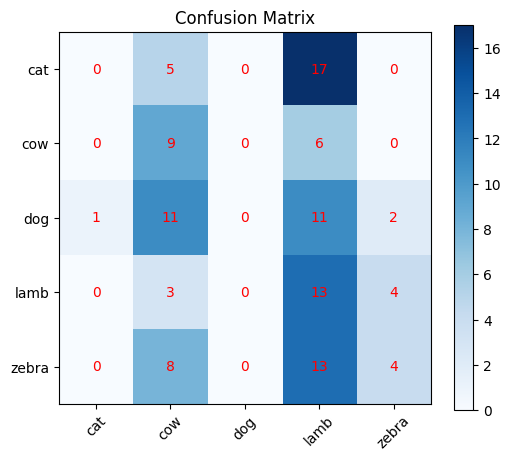

       precision  recall  f1-score
cat     0.000000    0.00  0.000000
cow     0.250000    0.60  0.352941
dog     0.000000    0.00  0.000000
lamb    0.216667    0.65  0.325000
zebra   0.400000    0.16  0.228571


In [1]:
# Naive Bayes Classifier (NumPy, Pandas, Matplotlib only)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

# =====================
# 1. Dataset loading
# =====================
DATASET_PATH = "/kaggle/input/animal-images/dataset"

# Get class names (subfolders)
classes = sorted(os.listdir(DATASET_PATH))

X, y = [], []

# Resize images for uniform shape
IMG_SIZE = (64, 64)  # smaller size for speed

for idx, cls in enumerate(classes):
    folder = os.path.join(DATASET_PATH, cls)
    for file in os.listdir(folder):
        if file.endswith((".jpg", ".png", ".jpeg")):
            img = imread(os.path.join(folder, file))
            if img.ndim == 3:  # convert to grayscale
                img = np.mean(img, axis=2)
            # Resize manually using slicing (very naive, no cv2/sklearn allowed)
            img = img[:IMG_SIZE[0], :IMG_SIZE[1]]  # crop/resize
            img = img.flatten()
            X.append(img)
            y.append(idx)

X = np.array(X)
y = np.array(y)

print("Dataset loaded:", X.shape, "Labels:", y.shape)

# =====================
# 2. Train-test split
# =====================
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.8 * len(X))  # 80-20 split
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# =====================
# 3. Naive Bayes Classifier
# =====================
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Mean and variance per class per feature
        self.mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self.var = np.zeros((n_classes, n_features), dtype=np.float64)
        self.priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0) + 1e-6  # avoid division by 0
            self.priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            # Gaussian likelihood
            numerator = -0.5 * np.sum(np.log(2. * np.pi * self.var[idx]))
            numerator -= 0.5 * np.sum(((x - self.mean[idx]) ** 2) / (self.var[idx]))
            posterior = prior + numerator
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

# =====================
# 4. Train & Predict
# =====================
nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print("Naive Bayes Accuracy:", accuracy)

# =====================
# 5. Confusion Matrix
# =====================
conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

plt.figure(figsize=(6,5))
plt.imshow(conf_matrix, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="red")
plt.show()

# =====================
# 6. Classification Report
# =====================
def classification_report(y_true, y_pred, classes):
    report = {}
    for idx, cls in enumerate(classes):
        tp = np.sum((y_true == idx) & (y_pred == idx))
        fp = np.sum((y_true != idx) & (y_pred == idx))
        fn = np.sum((y_true == idx) & (y_pred != idx))
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        report[cls] = {"precision": precision, "recall": recall, "f1-score": f1}
    return report

report = classification_report(y_test, y_pred, classes)
print(pd.DataFrame(report).T)